# Modelling and Evaluation

**Make sure that you have run data_collection.ipynb before running this one.**

## Objectives

- To address business requirement 2:
  - The client wants to know if a given image of a cherry leaf is healthy or shows powdery mildew.

## Inputs

This notebook will use the following inputs:

- inputs/cherry-leaves/cherry-leaves/test
- inputs/cherry-leaves/cherry-leaves/train
- inputs/cherry-leaves/cherry-leaves/validation
- outputs/v1/image_shape.pkl

## Outputs

This notebook will generate the following outputs:

- Plot showing the number of images in the train, validation, and test sets.
- Image augmentation.
- Class indices to change prediction inference in labels.
- Machine learning model creation and training.
- Saved model.
- Learning curve plot for model performance.
- Model evaluation on pickle file.
- Prediction on the random image file.

## Import packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import joblib
import pickle
import tensorflow
from matplotlib.image import imread
from PIL import Image


## Change working directory

By default, the working directory is "jupyter_notebooks", where the notebook is running. However, we need to change the working directory to its parent folder so that file references align with the broader project structure.

To do this, we first check the current working directory — note that the output below only displays the last two folders in the file path, rather than the full system path. This is done intentionally to prevent exposing the full local file path stored on my machine.

**Any time you revisit this notebook after logging out, or open a different notebook for the first time, you must repeat these steps to ensure the working directory is always correctly set.**

In [2]:
from pathlib import Path # ensure file path consistency

# Get the current working directory
current_dir = Path.cwd()

# Extract the last two directory names
filtered_path = Path(*current_dir.parts[-2:])
print(f"📂 {filtered_path}")  # Example output: 📂 mildew_detector/jupyter_notebooks

📂 mildew_detector\jupyter_notebooks


Now we change the working directory from "jupyter_notebooks" to the parent directory.

In [3]:
# Change the working directory to its parent folder
os.chdir(os.path.dirname(os.getcwd()))

# Confirmation message with
print("✅ You set a new current directory")

✅ You set a new current directory


Confirm the new current directory.

In [4]:
# Get the current working directory
current_dir = Path.cwd()

# Extract the last parent directory name
filtered_path = Path(*current_dir.parts[-1:])
print(f"📂 {filtered_path}")

📂 mildew_detector


## Set the input directories

Now we need to define the paths where this notebook will find the data we'll be using.

In [5]:
# Define base image data path
image_data = Path("inputs") / "cherry-leaves" / "cherry-leaves"

# Define paths for train, validation, and test sets
train_path = image_data / "train"
val_path = image_data / "validation"
test_path = image_data / "test"

# Print paths
print(f"📂 Train Path: {train_path}")
print(f"📂 Validation Path: {val_path}")
print(f"📂 Test Path: {test_path}")

📂 Train Path: inputs\cherry-leaves\cherry-leaves\train
📂 Validation Path: inputs\cherry-leaves\cherry-leaves\validation
📂 Test Path: inputs\cherry-leaves\cherry-leaves\test


### Confrim that the file paths are valid

Now we'll run a function just to check that the file paths defined above are valid.

The function will select one image from each train, test and validation folder and display it below along with the file path beginning with the "inputs" folder.

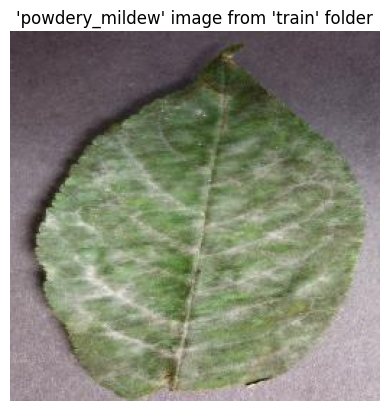

✅ random train image: inputs\cherry-leaves\cherry-leaves\train\powdery_mildew\8efb390e-1477-4de8-90cc-829adfc3e46c___FREC_Pwd.M 4987.JPG


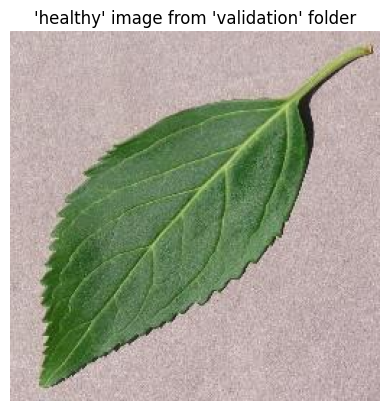

✅ random validation image: inputs\cherry-leaves\cherry-leaves\validation\healthy\9362fc4a-ac87-489d-8572-f15335af1387___JR_HL 9875_flipTB.JPG


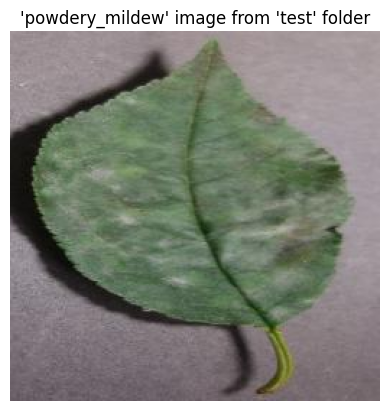

✅ random test image: inputs\cherry-leaves\cherry-leaves\test\powdery_mildew\167d6c02-d49c-4571-b9b8-6d77be09dfb4___FREC_Pwd.M 0256_flipLR.JPG


In [6]:
from pathlib import Path

# Function to find and display a random image from subfolders
def show_random_image(parent_folder):
    """
    Selects and displays a random image from a subfolder inside the given parent directory.

    Args:
        parent_folder (str or Path): The path to the main dataset folder (e.g., train, validation, test).

    Returns:
        str or None: The full path to the randomly selected image, or None if no images are found.
    """

    parent_folder = Path(parent_folder)  # Ensure it's a Path object

    # Ensure the parent folder exists
    if not parent_folder.exists():
        print(f"❌ path does not exist: {parent_folder}")
        return None

    # Scan subdirectories ('healthy', 'powdery_mildew')
    subfolders = [f for f in parent_folder.iterdir() if f.is_dir()]

    if not subfolders:
        print(f"⚠️ no subfolders found in: {parent_folder}")
        return None

    # Pick a random subfolder (class name)
    chosen_folder = random.choice(subfolders)

    # Find image files inside that subfolder
    image_files = [f for f in chosen_folder.iterdir() if f.suffix.lower() in {'.png', '.jpg', '.jpeg', '.bmp', '.webp'}]

    if not image_files:
        print(f"⚠️ no images found in: {chosen_folder}")
        return None

    # Select a random image and display it
    chosen_image = random.choice(image_files)

    # Load image using PIL
    image = Image.open(chosen_image)

    # Extract folder name ('healthy'/'powdery_mildew') and dataset section ('train'/'validation'/'test')
    class_name = chosen_folder.name
    dataset_section = parent_folder.name

    # Display the image with correct labeling
    plt.imshow(image)
    plt.title(f"'{class_name}' image from '{dataset_section}' folder")
    plt.axis("off")  # Hide axes for a cleaner look
    plt.show()

    return str(chosen_image)  # Return path for confirmation

# Fetch and display random images from each dataset section
train_image = show_random_image(train_path)
print(f"✅ random train image: {train_image}")

val_image = show_random_image(val_path)
print(f"✅ random validation image: {val_image}")

test_image = show_random_image(test_path)
print(f"✅ random test image: {test_image}")

### Set Output Directory

Create 📂 'output' directory if it doesn't already exist.

In [7]:
from pathlib import Path

# Define the root directory
root_dir = Path.cwd()  # Get current working directory
version = "v1"

# Construct the relative path for outputs
file_path = Path("outputs") / version

# Check if the directory for this version already exists
if file_path.exists():
    print(f'⚠️ Old version "{version}" already exists and the file path to it has just been set.') 
    print(f'Create a new version if required. If not, you are good to go!👍')
else:
    try:
        # Create the directory if it doesn't exist
        file_path.mkdir(parents=True, exist_ok=True)
        print(f'✅ Created new directory: 📂 {file_path}')
    except OSError as e:
        print(f'❌ Error creating directory: {e}')

⚠️ Old version "v1" already exists and the file path to it has just been set.
Create a new version if required. If not, you are good to go!👍


## Set the Label Names

Our upcoming binary classification task will require labeled data in order to train. Here we will set the labels to be used in our project:

- 'healthy'
- 'powdery_mildew'

In [8]:
# Set the labels
labels = os.listdir(train_path)
print('🏷️ The labels for the images are', labels)

🏷️ The labels for the images are ['healthy', 'powdery_mildew']


## Let's Count the Images

In the Data Collection notebook, we downloaded two directories of images:

- 📂healthy
- 📂powdery_mildew
  
We then split the images in each directory into three further folders:

- 📂test
- 📂train
- 📂validation

In this notebook, we now need to count how many images are in each of these six folders. We will create a loop to do the count then display the results in a plot.

📂 train - 🏷️ healthy: 1472 images
📂 train - 🏷️ powdery_mildew: 1472 images
📂 validation - 🏷️ healthy: 210 images
📂 validation - 🏷️ powdery_mildew: 210 images
📂 test - 🏷️ healthy: 422 images
📂 test - 🏷️ powdery_mildew: 422 images


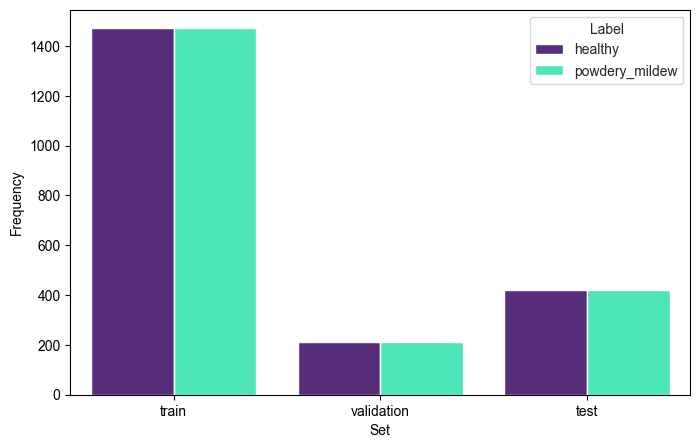

In [9]:
from pathlib import Path

# Create an empty dictionary
data = {
    'Set': [],
    'Label': [],
    'Frequency': []
}

# Define dataset partitions
folders = ['train', 'validation', 'test']

# Define root dataset directory
image_data = Path("inputs/cherry-leaves/cherry-leaves")
train_path = image_data / "train"
labels = [label.name for label in train_path.iterdir() if label.is_dir()]  # Extract directory names

# Collect data efficiently
for folder in folders:
    for label in labels:
        label_path = image_data / folder / label  # Use Path object
        num_images = len(list(label_path.glob("*"))) if label_path.exists() else 0  # Count files if path exists
        
        data['Set'].append(folder)
        data['Label'].append(label)
        data['Frequency'].append(num_images)

        print(f"📂 {folder} - 🏷️ {label}: {num_images} images")

# Convert to DataFrame
df_freq = pd.DataFrame(data)

# Create the figure object
fig, ax = plt.subplots(figsize=(8, 5))

# Define custom colors
custom_colors = ["#582088", "#33FFC29F"]  # Adjust HEX colors as required

# Plot with updated colors
sns.set_style("whitegrid")
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label', palette=custom_colors, ax=ax)

# Show plot (figure remains stored in 'fig' for later saving)
plt.show()

### Save the plot

If you're happy with the plot layout and colour scheme, save it in the 'outputs/v1' folder.

In [10]:
# Save the stored figure
fig.savefig(os.path.join(file_path, 'labels_distribution.png'), bbox_inches='tight', dpi=150)
print("✅ Plot saved successfully!")

✅ Plot saved successfully!


As we can see from the count, we have equal numbers of 'healthy' and 'powdery_mildew' images across the train, test and validation folders. Had the numbers been unequal, we would have given consideration to data balancing (oversampling or undersampling). As it stands, we don't need to do any data balancing so we can now move on to data augmentation.

## Data Augmentation

Currently all our images look roughly the same in terms of size, aspect and zoom, for exmaple. To build a more robust machine learning model we need to 'rough up' our dataset a little. Real world images won't always look like the unifom set of images that we downloaded so we need the model to learn using an 'augmented' dataset. An augmented dataset introduces variations such as random rotations, cropping, zoom adjustments, brightness shifts, and flipping to simulate the unpredictability of real-world images.

This process helps the model to generalize better by learning from a diverse set of image transformations. By applying augmentation techniques, we can effectively enhance the robustness of our machine learning model, making it more resilient to variations in new and unseen data.

So, let's get to it! 👍

### Import ImageDataGenerator

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Let's now define the adjustments that we want to make. Credit Code Institute WalkthroughProject01 for initial parameter selection.

In [12]:
augmented_image_data = ImageDataGenerator(
    rotation_range=25,  # More rotation to introduce stronger perspective shifts
    width_shift_range=0.15,  # Wider horizontal translations
    height_shift_range=0.15,  # Wider vertical translations
    shear_range=0.2,  # Stronger shearing for distortion effects
    zoom_range=0.2,  # More zoom variations to simulate different focal depths
    horizontal_flip=True,  # Mirroring images to improve orientation generalization
    vertical_flip=True,  # Vertical flips if objects don't depend on upright orientation
    brightness_range=(0.7, 1.3),  # Adjust brightness for lighting variations
    channel_shift_range=20,  # Shift pixel intensities for color variance
    fill_mode='nearest',  # Fill missing pixels using nearest neighbor interpolation
    rescale=1./255  # Normalization for pixel values
)

### Augmentation notes

We are going to be augmenting the image data in real-time, meaning that the images will be modified dynamically as they enter the model. This ensures that the model sees new variations of images in every epoch, helping it learn generalized patterns rather than memorizing specific features.

In the data visualization noteboook, we calculated the average image shape and stored that value in 'image_shape.pkl'. The model that we will be developing will need to know the dimensions of the images we will be training, so we need to define that here during the augmentation phase.

We may experiment with batch size as we fine-tune the model. Adjusting batch size impacts training speed and memory efficiency, so modify this value if needed to optimize performance.


### Extract image shape from .pkl

In [13]:
import pickle
from pathlib import Path

# Define the correct relative path
pkl_path = Path("outputs/v1/image_shape.pkl")

# Load image shape from the file
with pkl_path.open("rb") as f:
    image_shape = pickle.load(f)

print(f"✅ Using stored image shape: {image_shape}")

✅ Using stored image shape: (256, 256, 3)


### Augment the train image data

In [14]:
from pathlib import Path

# Define batch size for training
batch_size = 8  # Balances memory efficiency & training speed

# Convert train_path to a Path object
train_path = Path("inputs/cherry-leaves/cherry-leaves/train")  # Adjust if needed
if not train_path.exists():
    raise FileNotFoundError(f"⚠️ Training directory {train_path} not found!")

# Extract width & height from stored image shape
target_size = tuple(image_shape[:2])

# Load training dataset with augmentation
train_set = augmented_image_data.flow_from_directory(
    str(train_path),  # Convert Path to string for compatibility
    target_size=target_size,  # Uses shape from .pkl file
    color_mode="rgb",  # Ensures images are loaded in color
    batch_size=batch_size,  
    class_mode="binary",
    shuffle=True  # Prevents learning biases from order dependencies
)

# Check dataset summary
print(f"🛠️ Using batch size: {batch_size}")
print(f"📂 Found {train_set.samples} images belonging to {len(train_set.class_indices)} classes.")
print(f"🔍 Class mapping: {train_set.class_indices}")

# Load a sample batch to verify the image size
sample_images, _ = next(train_set)  # Fetch first batch
print(f"✅ Sample image batch shape: {sample_images.shape}")  # Expected: (batch_size, {target_size[0]}, {target_size[1]}, 3)

Found 2944 images belonging to 2 classes.
🛠️ Using batch size: 8
📂 Found 2944 images belonging to 2 classes.
🔍 Class mapping: {'healthy': 0, 'powdery_mildew': 1}
✅ Sample image batch shape: (8, 256, 256, 3)


### Augment test image data

Now, when it comes to augmenting test image data, we are only going to worry about resizing the images. This is because the test images should be as close as possible to the 'real world' images that will be uploaded by the users.

As you can see from the variable below, we are only going to make use of the rescale parameter in the ImageDataGenerator class.

In [15]:
from pathlib import Path

# Load image shape from stored .pkl file
pkl_path = Path("outputs/v1/image_shape.pkl")

if not pkl_path.exists():
    raise FileNotFoundError(f"⚠️ Image shape file {pkl_path} not found!")

with pkl_path.open("rb") as f:
    image_shape = pickle.load(f)

# Extract width & height
target_size = tuple(image_shape[:2])

# Define the correct test path
test_path = Path("inputs/cherry-leaves/cherry-leaves/test")

# Validate path existence to prevent errors
if not test_path.exists():
    raise FileNotFoundError(f"⚠️ Test directory {test_path} not found!")

# Load test dataset with augmentation
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(
    str(test_path),  # Ensure compatibility by converting Path to string
    target_size=target_size,  # Uses shape from .pkl file
    color_mode="rgb",  # Loads images in RGB format
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False  # Keeps data order unchanged for consistent evaluation
)

# Check dataset summary
print(f"🛠️ Using batch size: {batch_size}")  # Confirm batch size
print(f"📂 Found {test_set.samples} images belonging to {len(test_set.class_indices)} classes.")
print(f"🔍 Class mapping: {test_set.class_indices}")

# Load a sample batch to verify image size
sample_images, _ = next(test_set)  # Fetch first batch
print(f"✅ Sample image batch shape: {sample_images.shape}")  # Expected: (batch_size, {target_size[0]}, {target_size[1]}, 3)

Found 844 images belonging to 2 classes.
🛠️ Using batch size: 8
📂 Found 844 images belonging to 2 classes.
🔍 Class mapping: {'healthy': 0, 'powdery_mildew': 1}
✅ Sample image batch shape: (8, 256, 256, 3)


### Augment validation image data

The same logic applies to the validation image data. This should also match 'real world' data as closely as possible.

Notice that the basic code for augmenting the validation data is the same as that for the test data.

In [16]:
from pathlib import Path

# Load image shape from stored .pkl file
pkl_path = Path("outputs/v1/image_shape.pkl")

if not pkl_path.exists():
    raise FileNotFoundError(f"⚠️ Image shape file {pkl_path} not found!")

with pkl_path.open("rb") as f:
    image_shape = pickle.load(f)

# Extract width & height
target_size = tuple(image_shape[:2])

# Define the correct validation path
val_path = Path("inputs/cherry-leaves/cherry-leaves/validation")  # Adjust as needed

# Validate path existence to prevent errors
if not val_path.exists():
    raise FileNotFoundError(f"⚠️ Validation directory {val_path} not found!")

# Load validation dataset
val_set = ImageDataGenerator(rescale=1./255).flow_from_directory(
    str(val_path),  # Convert Path to string
    target_size=target_size,  # Uses shape from .pkl file
    color_mode="rgb",  # Loads images in RGB format
    batch_size=batch_size,  # Define batch size
    class_mode="binary",
    shuffle=True  # Ensures randomized batches for validation
)

# Print dataset summary
print(f"🛠️ Using batch size: {batch_size}")
print(f"📂 Found {val_set.samples} images belonging to {len(val_set.class_indices)} classes.")
print(f"🔍 Class mapping: {val_set.class_indices}")

# Load a sample batch to verify image size
sample_images, _ = next(val_set)  # Fetch first batch
print(f"✅ Sample image batch shape: {sample_images.shape}")  # Expected: (batch_size, {target_size[0]}, {target_size[1]}, 3)

Found 420 images belonging to 2 classes.
🛠️ Using batch size: 8
📂 Found 420 images belonging to 2 classes.
🔍 Class mapping: {'healthy': 0, 'powdery_mildew': 1}
✅ Sample image batch shape: (8, 256, 256, 3)


### Save class indices for later use

Let's now save the class indices into a .pkl file for later use. This will be required when deploying our model to ensure class labels remain consistent during inference (making predictions on unseen data).

In [17]:
from pathlib import Path

# Ensure file_path is a Path object
file_path = Path(file_path)

# Save class indices to a file using Pathlib
output_file = file_path / "class_indices.pkl"
joblib.dump(value=train_set.class_indices, filename=output_file)

print(f"📄 File saved: '{output_file}'")

📄 File saved: 'outputs\v1\class_indices.pkl'


### Let's take a look at some examples the augmented images

Before we start modelling, lets take a look at some samples of the augmented image data. The function below can be used to pull some random images from the directories.

In [18]:
def show_random_augmented_samples(train_set, val_set, test_set):
    """Displays three randomly selected augmented images from each dataset (train, validation, test) in a 3x3 plot."""
    
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    dataset_names = ["Train", "Validation", "Test"]
    datasets = [train_set, val_set, test_set]

    for col, (dataset_name, dataset) in enumerate(zip(dataset_names, datasets)):
        # Generate random indices for batch selection
        random_indices = np.random.randint(0, dataset.batch_size, 3)  

        for row, idx in enumerate(random_indices):  # Select images at random positions in batch
            img, label = next(dataset)  # Fetch a batch
            img = img[idx]  # Extract random image from batch
            
            axes[row, col].imshow(img)
            axes[row, col].axis("off")  # Hide axis for cleaner view
            if row == 0:  
                axes[row, col].set_title(dataset_name, fontsize=14, fontweight="bold")

    plt.tight_layout()
    plt.show()

Now call the function...

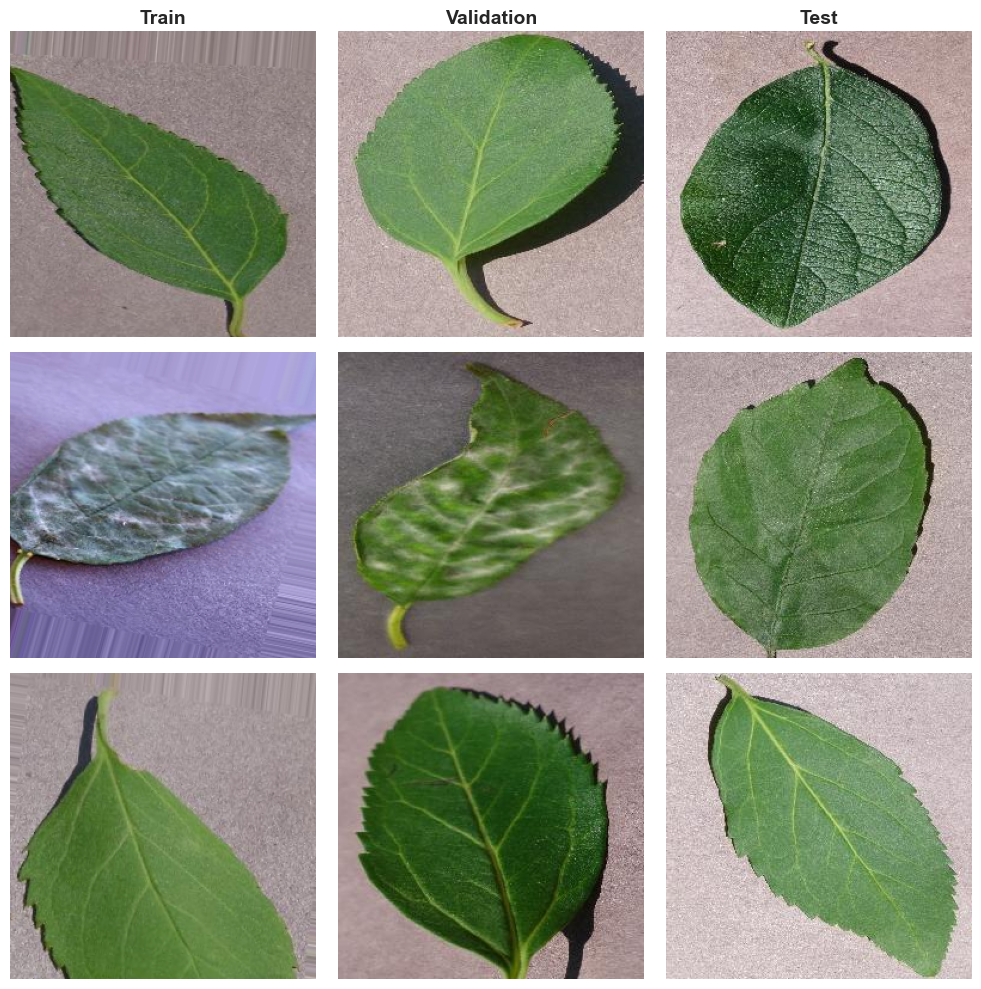

In [19]:
show_random_augmented_samples(train_set, val_set, test_set)

## The Model

Now we need to create a model that trains on our augmented dataset. This training will seek to identify patterns in the images and accurately classify cherry leaves as either healthy or affected by powdery mildew. 

This next step involves designing a deep learning model.


### Import the right tensor packages



In [20]:
import warnings
import tensorflow as tf
import sys
import re

# Suppress Keras warnings but keep them visible
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

# Suppress TensorFlow deprecation warnings properly
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Redirect standard error output to filter file paths while keeping warnings visible
class CleanLog:
    def write(self, message):
        # Mask file paths without removing the entire warning
        filtered_msg = re.sub(r"[A-Za-z]:\\\\(?:Users|AppData|Temp|.*?\\)", "[FILE PATH HIDDEN]\\", message)
        filtered_msg = re.sub(r"/(?:home|var|tmp|usr|.*?/)", "[FILE PATH HIDDEN]/", filtered_msg)  # UNIX Paths
        filtered_msg = re.sub(r"(ipykernel_\d+\\\d+\.py)", "[KERNEL FILE HIDDEN]", filtered_msg)  # Notebook-generated paths
        filtered_msg = re.sub(r"(ipykernel_\d+/\d+\.py)", "[KERNEL FILE HIDDEN]", filtered_msg)  # Alternative Jupyter formats

        sys.__stderr__.write(filtered_msg)  # Print filtered warnings to console

    def flush(self):
        sys.__stderr__.flush()

sys.stderr = CleanLog()

# Confirm TensorFlow version
print(f"✅ TensorFlow Version: {tf.__version__}")

✅ TensorFlow Version: 2.16.1


In [35]:
# Import TensorFlow components for model training
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

print("✅ TensorFlow methods imported successfully.")

✅ TensorFlow methods imported successfully.


### Define the model

Credit Code Institite WalkthoughProject01 for this model.

In [23]:

def create_tf_model():
    model = Sequential()

    # Explicit Input Layer to avoid Sequential warnings
    # Image shape is the target_size variable that we defined when augmenting the train set
    model.add(Input(shape=(target_size[0], target_size[1], 3)))  
    
    # First Convolutional Layer
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional Layer
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third Convolutional Layer
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flattening
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    # Regularization to help prevent overfitting
    model.add(Dropout(0.5))

    # Output Layer (Binary Classification)
    model.add(Dense(1, activation='sigmoid'))

    # Compile Model
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=0.001), 
                  metrics=['accuracy'])

    return model

# Debug: Display Model Summary
model = create_tf_model()

#### Create a model summary

We do this so that we can visually inspect the model architecture, verify layer configurations, check input/output shapes, and ensure the number of trainable parameters aligns with our expectations before training begins.


In [24]:
create_tf_model().summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,429,377 (28.34 MB)

 Trainable params: 7,429,377 (28.34 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
model.layers[-1].activation

<function keras.src.activations.activations.sigmoid(x)>

#### Early stopping

As the model learns it should get more accutrate over the epochs. At some point, the learning will slow and imporvements will become minimal. Once this begins to happen, we can stop the training early to help prevent overfitting, ensuring the model does not memorize the training data but generalizes well on unseen data.

The varibale below can be used to stop the training when after 3 epochs (patience=3), value loss stops improving (monitor='val_loss'). This variable will also restore the weights from the best performing epoch (restore_best_weights=True) which will then become the inference model used by the client.

In [25]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Before fitting the model, lets just check how the training data is broken down.

In [26]:
print(f"📸 Total training images: {train_set.samples}")  
print(f"🛠️ Batch size: {batch_size}")  
print(f"🧮 Calculated steps_per_epoch: {train_set.samples // batch_size}")  

📸 Total training images: 2944
🛠️ Batch size: 8
🧮 Calculated steps_per_epoch: 368


In [27]:
# fit model for training

# Create the model
model = create_tf_model()

# Train the model
steps_per_epoch = train_set.samples // batch_size  # Auto-define steps per epoch

model.fit(train_set,
              epochs=25,
              steps_per_epoch=steps_per_epoch,  
              validation_data=val_set,
              callbacks=[early_stop],
              verbose=1)

Epoch 1/25
368/368 ━━━━━━━━━━━━━━━━━━━━ 68s 182ms/step - accuracy: 0.7029 - loss: 0.5690 - val_accuracy: 0.9262 - val_loss: 0.1504
Epoch 2/25
368/368 ━━━━━━━━━━━━━━━━━━━━ 55s 149ms/step - accuracy: 0.9372 - loss: 0.1904 - val_accuracy: 0.9405 - val_loss: 0.1503
Epoch 3/25
368/368 ━━━━━━━━━━━━━━━━━━━━ 56s 153ms/step - accuracy: 0.9494 - loss: 0.1441 - val_accuracy: 0.9952 - val_loss: 0.0477
Epoch 4/25
368/368 ━━━━━━━━━━━━━━━━━━━━ 58s 157ms/step - accuracy: 0.9749 - loss: 0.0848 - val_accuracy: 0.9976 - val_loss: 0.0382
Epoch 5/25
368/368 ━━━━━━━━━━━━━━━━━━━━ 58s 157ms/step - accuracy: 0.9836 - loss: 0.0626 - val_accuracy: 0.9786 - val_loss: 0.0813
Epoch 6/25
368/368 ━━━━━━━━━━━━━━━━━━━━ 58s 157ms/step - accuracy: 0.9741 - loss: 0.0915 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 7/25
368/368 ━━━━━━━━━━━━━━━━━━━━ 59s 159ms/step - accuracy: 0.9764 - loss: 0.0959 - val_accuracy: 0.9810 - val_loss: 0.0772
Epoch 8/25
368/368 ━━━━━━━━━━━━━━━━━━━━ 58s 158ms/step - accuracy: 0.9841 - loss: 0

#### Save model

Now we save the model with the best weights to a .keras file.

In [28]:
save_path = 'outputs/v1/mildew_detector_model.keras'
model.save(save_path)
print(f"📄 File saved: '{save_path}'")

📄 File saved: 'outputs/v1/mildew_detector_model.keras'


#### Model performance

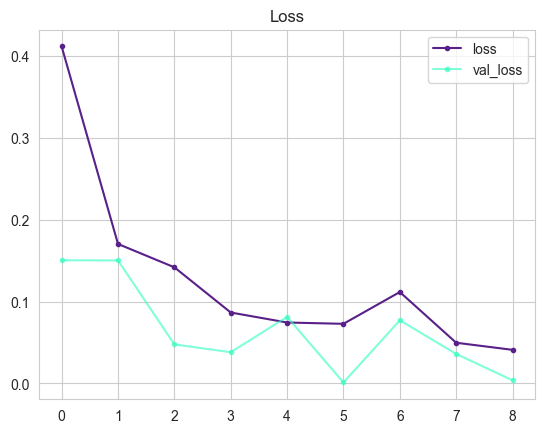

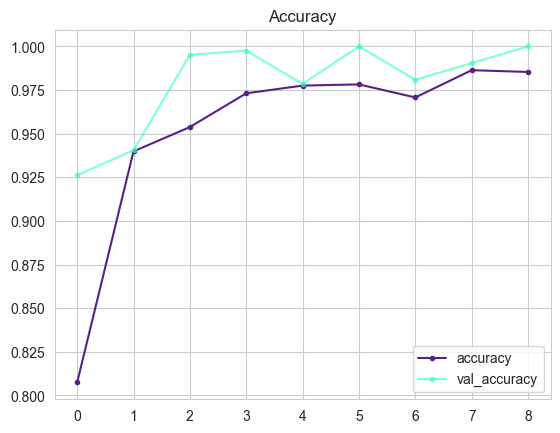

In [29]:
custom_colors = ["#582088", "#33FFC29F"]

losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")

# Apply custom colors to loss plot
losses[['loss', 'val_loss']].plot(style='.-', color=custom_colors)
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")

# Apply custom colors to accuracy plot
losses[['accuracy', 'val_accuracy']].plot(style='.-', color=custom_colors)
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

#### Model evaluation

In [30]:
from keras.models import load_model
model = load_model('outputs/v1/mildew_detector_model.keras')

In [31]:

evaluation = model.evaluate(test_set)

106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.9970 - loss: 0.0175


In [32]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

#### Predict on new data